# Курсовая работа по теме
"Прогнозирование результатов матчей по футболу с использованием методов машинного обучения"

Идея здесь состоит в том, чтобы смоделировать игры чемпионата мира по футболу FIFA 2022 с помощью машинного обучения, чтобы предсказать победителя соревнования. В проекте используются два набора данных:
#### Результаты международного футбола с 1872 по 2022 год 
Этот набор данных включает 44 341 результат международных футбольных матчей, начиная с самого первого официального матча в 1872 году и заканчивая 2023 годом 29 марта. Матчи варьируются от чемпионата мира по футболу до обычных товарищеских матчей. Матчи строго мужские, и данные не включают Олимпийские игры или матчи, в которых хотя бы одна из команд была сборной страны B, U-23 или сборной лиги.

<br>results.csv включает следующие столбцы:
  - date - дата матча 
  - home_team - домашняя команда 
  - away_team - команда гостей
  - home_score - счет хозяев поля, включая дополнительное время, не включая серию пенальти
  - away_score - счет гостей поля, включая дополнительное время, не включая серию пенальти
  - tournament - название турнира
  - city - город, где этот матч был сыгран
  - country - страна, где этот матч был сыгран
  - neutral - столбец TRUE/FALSE, указывающий, был ли матч сыгран на нейтральной площадке.
  
#### FIFA Мировой рейтинг 1992-2022 гг.

Этот набор данных включает в себя рейтинг сборных команд стран по футболу и дополнительные метрики

<br>fifa_ranking.csv включает следующие столбцы:
  - country_full — полное название страны
  - country_abrv — короткое название страны 
  - rank — текущий рейтинг страны
  - total_points — текущие набранные очки в рейтинге
  - previous_points — общее количество очков в последнем рейтинге
  - rank_change — как изменился рейтинг с момента последней публикации
  - confederation — FIFA конфедерации
  - rank_date — дата расчета рейтинга

Я моделирую задачу как задачу бинарной классификации. Я использовал это, чтобы упростить анализ результатов модели, поэтому модель предсказываю между победой домашней команды и ничьей/победой выездной команды.

Для начала импортируем библиотеки

In [3]:
import numpy as np 
import pandas as pd 
import os
import re
!pip install xgboost
import xgboost as xgb
import sklearn
from xgboost import XGBClassifier
from xgboost import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

### Подготовка данных
Здесь я подготовлю данные для применения методов разработки признаков, которые создадут базу данных для применения алгоритмов машинного обучения. Здесь большую роль будет играть знание библиотеки Pandas.


Первый датасет с результатами матчей

In [4]:
df =  pd.read_csv("C:/Users/Ivan/Desktop/Курсовая/archive/results.csv")

Вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44557 entries, 0 to 44556
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        44557 non-null  object
 1   home_team   44557 non-null  object
 2   away_team   44557 non-null  object
 3   home_score  44557 non-null  int64 
 4   away_score  44557 non-null  int64 
 5   tournament  44557 non-null  object
 6   city        44557 non-null  object
 7   country     44557 non-null  object
 8   neutral     44557 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.8+ MB


Преобразовать дату в дату и время dtype

In [6]:
df["date"] = pd.to_datetime(df["date"])

### Отсутствующие значения
Данные могут иметь пропущенные значения. 

In [7]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

В наборе данных нет пропущенных значений.

Используем все игры, сыгранные с 2010 года.

In [9]:
df = df[(df["date"] >= "2010-8-1")].reset_index(drop=True)

In [10]:
df.sort_values("date").head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2010-08-04,Botswana,Zimbabwe,2,0,Friendly,Selebi-Phikwe,Botswana,False
1,2010-08-08,Anguilla,Saint Martin,1,3,Friendly,The Valley,Anguilla,False
2,2010-08-10,Bosnia and Herzegovina,Qatar,1,1,Friendly,Sarajevo,Bosnia and Herzegovina,False
3,2010-08-10,Italy,Ivory Coast,0,1,Friendly,London,England,True
4,2010-08-10,United States,Brazil,0,2,Friendly,East Rutherford,United States,False


Теперь мы используем датасет рейтинга FIFA

In [11]:
rank = pd.read_csv("C:/Users/Ivan/Desktop/Курсовая/fifa_ranking/fifa_ranking.csv")

In [12]:
rank.head(10)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,74,Madagascar,MAD,18.0,0.0,0,CAF,1992-12-31
1,52,Qatar,QAT,27.0,0.0,0,AFC,1992-12-31
2,51,Senegal,SEN,27.0,0.0,0,CAF,1992-12-31
3,50,El Salvador,SLV,28.0,0.0,0,CONCACAF,1992-12-31
4,49,Korea Republic,KOR,28.0,0.0,0,AFC,1992-12-31
5,48,Saudi Arabia,KSA,28.0,0.0,0,AFC,1992-12-31
6,47,Chile,CHI,28.0,0.0,0,CONMEBOL,1992-12-31
7,53,Malawi,MWI,27.0,0.0,0,CAF,1992-12-31
8,46,Iceland,ISL,29.0,0.0,0,UEFA,1992-12-31
9,44,Finland,FIN,31.0,0.0,0,UEFA,1992-12-31


In [13]:
rank.isna().sum()

rank               0
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

Здесь также возьмем рейтинг команд с 2010 года

In [14]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2010-8-1")].reset_index(drop=True)

Некоторые команды на чемпионате мира имеют разные названия в наборе данных рейтинга

In [15]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

In [16]:
rank.head(10)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,69,Uganda,UGA,459.0,457.0,-1,CAF,2010-08-11
1,66,South Africa,RSA,504.0,504.0,0,CAF,2010-08-11
2,68,Bahrain,BHR,466.0,460.0,-1,AFC,2010-08-11
3,73,Montenegro,MNE,448.0,448.0,1,UEFA,2010-08-11
4,70,Albania,ALB,455.0,455.0,-1,UEFA,2010-08-11
5,72,Zambia,ZAM,449.0,446.0,-1,CAF,2010-08-11
6,66,FYR Macedonia,MKD,504.0,504.0,0,UEFA,2010-08-11
7,74,Malawi,MWI,424.0,425.0,0,CAF,2010-08-11
8,75,Togo,TOG,421.0,421.0,0,CAF,2010-08-11
9,70,Saudi Arabia,KSA,455.0,471.0,2,AFC,2010-08-11


In [17]:
rank[rank.country_full=='Portugal']

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
102,8,Portugal,POR,1062.00,1062.00,0,UEFA,2010-08-11
262,8,Portugal,POR,1049.00,1062.00,0,UEFA,2010-09-15
516,8,Portugal,POR,1123.00,1049.00,0,UEFA,2010-10-20
764,8,Portugal,POR,1102.00,1123.00,0,UEFA,2010-11-17
986,8,Portugal,POR,1090.00,1102.00,0,UEFA,2010-12-15
...,...,...,...,...,...,...,...,...
26124,8,Portugal,POR,1674.78,1660.25,0,UEFA,2022-03-31
26255,9,Portugal,POR,1678.65,1674.78,1,UEFA,2022-06-23
26468,9,Portugal,POR,1678.65,1678.65,0,UEFA,2022-08-25
26681,9,Portugal,POR,1676.56,1678.65,0,UEFA,2022-10-06


In [18]:
rank.rank_date.unique()

array(['2010-08-11T00:00:00.000000000', '2010-09-15T00:00:00.000000000',
       '2010-10-20T00:00:00.000000000', '2010-11-17T00:00:00.000000000',
       '2010-12-15T00:00:00.000000000', '2011-01-12T00:00:00.000000000',
       '2011-02-02T00:00:00.000000000', '2011-03-09T00:00:00.000000000',
       '2011-04-13T00:00:00.000000000', '2011-05-18T00:00:00.000000000',
       '2011-06-29T00:00:00.000000000', '2011-07-27T00:00:00.000000000',
       '2011-08-24T00:00:00.000000000', '2011-09-21T00:00:00.000000000',
       '2011-10-19T00:00:00.000000000', '2011-11-23T00:00:00.000000000',
       '2011-12-21T00:00:00.000000000', '2012-01-18T00:00:00.000000000',
       '2012-02-15T00:00:00.000000000', '2012-03-07T00:00:00.000000000',
       '2012-04-11T00:00:00.000000000', '2012-05-09T00:00:00.000000000',
       '2012-06-06T00:00:00.000000000', '2012-07-04T00:00:00.000000000',
       '2012-08-08T00:00:00.000000000', '2012-09-05T00:00:00.000000000',
       '2012-10-03T00:00:00.000000000', '2012-11-07

In [19]:
rank.set_index(['rank_date'])

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
rank_date,,,,,,,
2010-08-11,69,Uganda,UGA,459.00,457.00,-1,CAF
2010-08-11,66,South Africa,RSA,504.00,504.00,0,CAF
2010-08-11,68,Bahrain,BHR,466.00,460.00,-1,AFC
2010-08-11,73,Montenegro,MNE,448.00,448.00,1,UEFA
2010-08-11,70,Albania,ALB,455.00,455.00,-1,UEFA
...,...,...,...,...,...,...,...
2022-12-22,136,Solomon Islands,SOL,1095.70,1095.70,0,OFC
2022-12-22,135,Turkmenistan,TKM,1100.47,1100.47,0,AFC
2022-12-22,134,Philippines,PHI,1113.15,1115.13,1,AFC


In [20]:
(rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first()).dropna(axis=0)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
rank_date,,,,,,,
2010-08-11,195.0,Afghanistan,AFG,13.00,17.00,2.0,AFC
2010-09-15,194.0,Afghanistan,AFG,13.00,13.00,-1.0,AFC
2010-10-20,196.0,Afghanistan,AFG,10.00,13.00,2.0,AFC
2010-11-17,195.0,Afghanistan,AFG,10.00,10.00,-1.0,AFC
2010-12-15,195.0,Afghanistan,AFG,10.00,10.00,0.0,AFC
...,...,...,...,...,...,...,...
2022-03-31,122.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
2022-06-23,123.0,Zimbabwe,ZIM,1138.56,1138.56,1.0,CAF
2022-08-25,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF


In [21]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

## Очистка, отбор и создание новых признаков

In [22]:
rank

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2010-08-11,195.0,Afghanistan,AFG,13.00,17.00,2.0,AFC
1,2010-08-12,195.0,Afghanistan,AFG,13.00,17.00,2.0,AFC
2,2010-08-13,195.0,Afghanistan,AFG,13.00,17.00,2.0,AFC
3,2010-08-14,195.0,Afghanistan,AFG,13.00,17.00,2.0,AFC
4,2010-08-15,195.0,Afghanistan,AFG,13.00,17.00,2.0,AFC
...,...,...,...,...,...,...,...,...
946505,2022-12-18,125.0,Zimbabwe,ZIM,1138.56,1138.56,2.0,CAF
946506,2022-12-19,125.0,Zimbabwe,ZIM,1138.56,1138.56,2.0,CAF
946507,2022-12-20,125.0,Zimbabwe,ZIM,1138.56,1138.56,2.0,CAF
946508,2022-12-21,125.0,Zimbabwe,ZIM,1138.56,1138.56,2.0,CAF


In [23]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2010-08-04,Botswana,Zimbabwe,2,0,Friendly,Selebi-Phikwe,Botswana,False
1,2010-08-08,Anguilla,Saint Martin,1,3,Friendly,The Valley,Anguilla,False
2,2010-08-10,Bosnia and Herzegovina,Qatar,1,1,Friendly,Sarajevo,Bosnia and Herzegovina,False
3,2010-08-10,Italy,Ivory Coast,0,1,Friendly,London,England,True
4,2010-08-10,United States,Brazil,0,2,Friendly,East Rutherford,United States,False
...,...,...,...,...,...,...,...,...,...
11939,2023-03-28,Haiti,Bermuda,3,1,CONCACAF Nations League,San Cristóbal,Dominican Republic,True
11940,2023-03-28,Guyana,Montserrat,0,0,CONCACAF Nations League,Bridgetown,Barbados,True
11941,2023-03-28,Bonaire,Turks and Caicos Islands,1,2,CONCACAF Nations League,Rincon,Bonaire,False
11942,2023-03-28,United States Virgin Islands,Sint Maarten,1,2,CONCACAF Nations League,Saint Croix,United States Virgin Islands,False


In [24]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

In [25]:
df_wc_ranked

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points,previous_points,rank,rank_change
0,2010-08-11,Albania,Uzbekistan,1,0,Friendly,Durrës,Albania,False,455.00,455.00,70.0,-1.0
1,2010-08-11,Algeria,Gabon,1,2,Friendly,Algiers,Algeria,False,759.00,759.00,33.0,0.0
2,2010-08-11,Angola,Uruguay,0,2,Friendly,Lisbon,Portugal,True,357.00,356.00,87.0,1.0
3,2010-08-11,Armenia,Iran,1,3,Friendly,Yerevan,Armenia,False,318.00,318.00,96.0,0.0
4,2010-08-11,Austria,Switzerland,0,1,Friendly,Klagenfurt,Austria,False,536.00,536.00,60.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10680,2022-12-14,Thailand,Taiwan,0,1,Friendly,Pathum Thani,Thailand,False,1174.92,1170.69,111.0,0.0
10681,2022-12-14,Vietnam,Philippines,1,0,Friendly,Hanoi,Vietnam,False,1226.65,1218.84,96.0,-1.0
10682,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0
10683,2022-12-17,Singapore,Maldives,3,1,Friendly,Singapore,Singapore,False,1003.50,1004.75,160.0,1.0


In [26]:
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", 
    "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], 
                                  suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [27]:
df_wc_ranked

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2010-08-11,Albania,Uzbekistan,1,0,Friendly,Durrës,Albania,False,455.00,455.00,70.0,-1.0,351.00,352.00,88.0,1.0
1,2010-08-11,Algeria,Gabon,1,2,Friendly,Algiers,Algeria,False,759.00,759.00,33.0,0.0,755.00,755.00,34.0,0.0
2,2010-08-11,Angola,Uruguay,0,2,Friendly,Lisbon,Portugal,True,357.00,356.00,87.0,1.0,1152.00,1152.00,6.0,0.0
3,2010-08-11,Armenia,Iran,1,3,Friendly,Yerevan,Armenia,False,318.00,318.00,96.0,0.0,517.00,522.00,65.0,1.0
4,2010-08-11,Austria,Switzerland,0,1,Friendly,Klagenfurt,Austria,False,536.00,536.00,60.0,0.0,940.00,940.00,17.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,2022-12-14,Malaysia,Maldives,3,0,Friendly,Kuala Lumpur,Malaysia,False,1062.32,1057.59,146.0,-2.0,1026.09,1018.25,154.0,-2.0
9972,2022-12-14,Vietnam,Philippines,1,0,Friendly,Hanoi,Vietnam,False,1226.65,1218.84,96.0,-1.0,1115.13,1115.13,133.0,-1.0
9973,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0,1563.50,1558.35,22.0,-1.0
9974,2022-12-17,Singapore,Maldives,3,1,Friendly,Singapore,Singapore,False,1003.50,1004.75,160.0,1.0,1026.09,1018.25,154.0,-2.0


Теперь есть готовые данные для создания функций на основе результатов игр и рейтинга FIFA.

## Особенности Инжиниринг
Идея здесь состоит в том, чтобы создать возможные функции, которые повлияют на прогнозирование футбольных матчей. Воздействующие функции могут быть следующими:

- Прошлые игровые очки набраны
- Прошлые забитые и пропущенные голы
- Важность игры (товарищеской или нет)
- Рейтинг команд
- Повышение рейтинга команд
- Полученные и потерянные очки в рейтинге


Итак, первое, что нужно сделать, это создать функцию, которая говорит, какая команда выиграла и сколько очков они набрали в игре.

In [28]:
df = df_wc_ranked

In [29]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)
df[["result", "home_team_points", "away_team_points"]] = results

Игровые очки составляют 3 за победу, 1 за ничью и 0 за проигрыш и отличаются от ранговых очков FIFA, которые уже есть в базе данных. 

### Визуализация данных


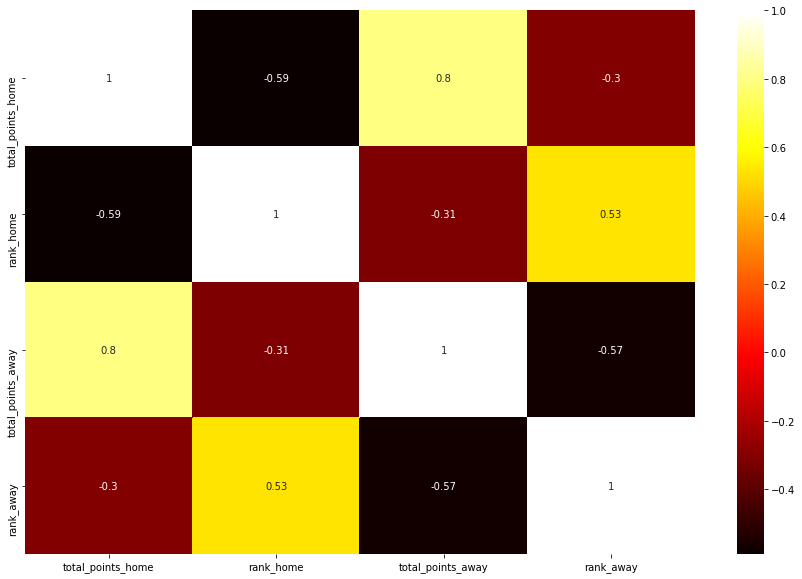

In [30]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr(),annot=True,cmap="hot")
plt.show()

Теперь cоздам столбцы, которые помогут в создании функций: разница в рейтинге, очки, набранные в игре, по сравнению с рейтингом команды, а также разница голов в игре. Все функции, не являющиеся различиями, должны быть созданы для двух команд (в гостях и дома).

In [31]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [32]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points,rank_dif,sg,points_home_by_rank,points_away_by_rank
0,2010-08-11,Albania,Uzbekistan,1,0,Friendly,Durrës,Albania,False,455.00,...,352.00,88.0,1.0,0,3,0,-18.0,1,0.034091,0.000000
1,2010-08-11,Algeria,Gabon,1,2,Friendly,Algiers,Algeria,False,759.00,...,755.00,34.0,0.0,1,0,3,-1.0,-1,0.000000,0.090909
2,2010-08-11,Angola,Uruguay,0,2,Friendly,Lisbon,Portugal,True,357.00,...,1152.00,6.0,0.0,1,0,3,81.0,-2,0.000000,0.034483
3,2010-08-11,Armenia,Iran,1,3,Friendly,Yerevan,Armenia,False,318.00,...,522.00,65.0,1.0,1,0,3,31.0,-2,0.000000,0.031250
4,2010-08-11,Austria,Switzerland,0,1,Friendly,Klagenfurt,Austria,False,536.00,...,940.00,17.0,-1.0,1,0,3,43.0,-1,0.000000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,2022-12-14,Malaysia,Maldives,3,0,Friendly,Kuala Lumpur,Malaysia,False,1062.32,...,1018.25,154.0,-2.0,0,3,0,-8.0,3,0.019481,0.000000
9972,2022-12-14,Vietnam,Philippines,1,0,Friendly,Hanoi,Vietnam,False,1226.65,...,1115.13,133.0,-1.0,0,3,0,-37.0,1,0.022556,0.000000
9973,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,...,1558.35,22.0,-1.0,0,3,0,-10.0,1,0.136364,0.000000
9974,2022-12-17,Singapore,Maldives,3,1,Friendly,Singapore,Singapore,False,1003.50,...,1018.25,154.0,-2.0,0,3,0,6.0,2,0.019481,0.000000


Чтобы создать функции, я разделю набор данных в наборе данных домашней и гостевой команд, объединю их и рассчитаю значения прошлых игр. После этого я снова разделю и объединим их, получив исходный набор данных. Этот процесс оптимизирует создание функций.

In [33]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away", "rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home", "rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [34]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [35]:
team_stats = home_team.append(away_team)

Этот столбец будет использоваться для расчета признаков для моделирования

In [101]:
team_stats_raw = team_stats.copy()

Теперь у нас есть данные, готовые для создания прогностических функций. Это будут:

- Средние голы команды в цикле Кубка мира.
- Средние голы команды в последних 5 играх.
- Среднее количество голов, забитых командой в цикле Кубка мира.
- Среднее количество голов, забитых командой в последних 5 играх.
- Средний рейтинг ФИФА, с которым команда столкнулась в цикле чемпионата мира.
- Средний рейтинг FIFA, с которым команда сталкивалась в последних 5 играх.
- Очки FIFA, выигранные в цикле.
- Очки FIFA, полученные в последних 5 играх.
- Средние игровые очки в цикле.
- Среднее количество игровых очков за последние 5 игр.
- Средние игровые очки по рангам, с которыми столкнулись в цикле.
- Средние игровые очки по рангам, с которыми они сталкивались в последних 5 играх.

In [37]:
stats_val = [] #Мы добавим сюда важную статистику

for index, row in team_stats.iterrows(): # Перебор строк team_stats
    team = row["team"]
    date = row["date"]
    # получить past_games данной команды
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    # получить последние 5 игр
    last5 = past_games.head(5)
    
    if len(last5) > 0:
        # Если есть последние 5 игр команды
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    # получение средних голов прошлых игр, сделанных данной командой
    goals = past_games["score"].mean()
    # Последние 5 средних голов, забитых данной командой
    goals_l5 = last5["score"].mean()
    
    # Среднее количество голов с учетом проигранной команды
    goals_suf = past_games["suf_score"].mean()
    # Среднее количество голов, забитых проигранной командой в последних 5 играх
    goals_suf_l5 = last5["suf_score"].mean()
    
    # Средний рейтинг команды гостей
    rank = past_games["rank_suf"].mean()
    # Средний рейтинг команды гостей за последние 5 игр
    rank_l5 = last5["rank_suf"].mean()
    
    
    
    # Возьмите средние командные очки прошлых игр
    gp = past_games["team_points"].mean()
    # Возьмите средние командные очки в 5 прошлых играх
    gp_l5 = last5["team_points"].mean()
    
    # Набранные очки по рангу прошлых игр
    gp_rank = past_games["points_by_rank"].mean()
    # Набранные очки по рангу за последние 5 игр
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [38]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols) # Создание данных из stats_df

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False) # Добавление этих столбцов в team_stats df

In [39]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:] # Получение статистики домашней команды
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:] # Получение статистики гостевой команды

Новые колонки :

In [40]:
home_team_stats.columns

Index(['date', 'team', 'score', 'suf_score', 'rank', 'rank_suf', 'rank_change',
       'total_points', 'result', 'rank_dif', 'points_by_rank', 'team_points',
       'goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

Получение только тех столбцов, с которыми мы хотим работать

In [41]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [42]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Чтобы унифицировать базу данных, необходимо добавить суффикс «home» и «away» для каждого столбца. После этого данные готовы к объединению.

In [43]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [44]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [45]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Теперь, чтобы количественно оценить важность игры, создается столбец для поиска товарищеский ли матч

In [46]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [47]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"],drop_first=True)

In [48]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [49]:
full_df.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_1
9971,2022-12-14,Malaysia,Maldives,3,0,Friendly,Kuala Lumpur,Malaysia,False,1062.32,...,1.6,150.747126,154.4,901.25,-7.25,1.149425,1.8,0.006752,0.009363,1
9972,2022-12-14,Vietnam,Philippines,1,0,Friendly,Hanoi,Vietnam,False,1226.65,...,1.6,147.000000,150.4,1050.89,-12.02,1.427350,0.8,0.008954,0.004550,1
9973,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,...,0.6,73.301471,12.6,1192.50,0.00,1.845588,2.0,0.043631,0.409872,0
9974,2022-12-17,Singapore,Maldives,3,1,Friendly,Singapore,Singapore,False,1003.50,...,1.6,150.693182,161.4,909.09,0.59,1.136364,1.8,0.006675,0.009363,1
9975,2022-12-18,Argentina,France,3,3,FIFA World Cup,Lusail,Qatar,True,1773.88,...,0.8,37.717791,18.6,869.78,0.00,2.116564,2.4,0.162486,0.230350,0


И, после этого, мы выбираем только столбцы, которые помогут в анализе признаков.

  'tournament', 'city', 'country', 'neutral', 'total_points_home',
   'previous_points_home', 
    'total_points_away', 'previous_points_away', 
    'home_team_points', 'away_team_points',
     'sg', 'points_home_by_rank', 'points_away_by_rank',

In [50]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score", "result", "rank_dif", 
        "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,away_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_1
9971,2022-12-14,Malaysia,Maldives,146.0,154.0,3,0,0,-8.0,-2.0,...,-7.25,1.335938,1.6,0.008598,0.010218,1.149425,1.8,0.006752,0.009363,1
9972,2022-12-14,Vietnam,Philippines,96.0,133.0,1,0,0,-37.0,-1.0,...,-12.02,1.536842,2.0,0.011456,0.022238,1.427350,0.8,0.008954,0.004550,1
9973,2022-12-17,Croatia,Morocco,12.0,22.0,2,1,0,-10.0,-3.0,...,0.00,1.777027,1.2,0.081854,0.322967,1.845588,2.0,0.043631,0.409872,0
9974,2022-12-17,Singapore,Maldives,160.0,154.0,3,1,0,6.0,1.0,...,0.59,1.194915,1.0,0.007872,0.007240,1.136364,1.8,0.006675,0.009363,1
9975,2022-12-18,Argentina,France,3.0,4.0,3,3,2,-1.0,0.0,...,0.00,2.060606,2.6,0.188424,0.160020,2.116564,2.4,0.162486,0.230350,0


In [51]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

Игры с NA — это те, которые не могут быть рассчитаны. Они будут сброшены.

In [52]:
base_df_no_fg = base_df.dropna()

In [53]:
base_df_no_fg.isna().sum()

date                             0
home_team                        0
away_team                        0
rank_home                        0
rank_away                        0
home_score                       0
away_score                       0
result                           0
rank_dif                         0
rank_change_home                 0
rank_change_away                 0
home_goals_mean                  0
home_goals_mean_l5               0
home_goals_suf_mean              0
home_goals_suf_mean_l5           0
home_rank_mean                   0
home_rank_mean_l5                0
home_points_mean                 0
home_points_mean_l5              0
away_goals_mean                  0
away_goals_mean_l5               0
away_goals_suf_mean              0
away_goals_suf_mean_l5           0
away_rank_mean                   0
away_rank_mean_l5                0
away_points_mean                 0
away_points_mean_l5              0
home_game_points_mean            0
home_game_points_mea

## Анализ данных
Теперь нам нужно проанализировать все созданные функции и проверить, обладают ли они предсказательной силой. Кроме того, если их нет, нам нужно создать некоторые из них, например различия между домашней и гостевой командами. Чтобы проанализировать предсказательную силу, я назначу ничью как проигрыш хозяев поля.

In [54]:
df = base_df_no_fg

In [55]:
df.columns

Index(['date', 'home_team', 'away_team', 'rank_home', 'rank_away',
       'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home',
       'rank_change_away', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
       'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
       'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
       'away_points_mean', 'away_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'is_friendly_1'],
      dtype='object')

In [56]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df.loc[:,'result'] = df["result"].apply(lambda x: no_draw(x))

C:\Users\Ivan\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [57]:
df.columns

Index(['date', 'home_team', 'away_team', 'rank_home', 'rank_away',
       'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home',
       'rank_change_away', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
       'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
       'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
       'away_points_mean', 'away_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'is_friendly_1'],
      dtype='object')

In [ ]:
data1 = df[list(df.columns[7:20].values)]
data2 = df[list(df.columns[20:].values)+['result']]

In [59]:
scaled = (data1[1:] - data1[1:].mean()) / data1[1:].std()
scaled["result"] = data1["result"]
violin1 = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

scaled = (data2[:-2] - data2[:-2].mean()) / data2[:-2].std()
scaled["result"] = data2["result"]
scaled['is_friendly_1'] = data2['is_friendly_1']
violin2 = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

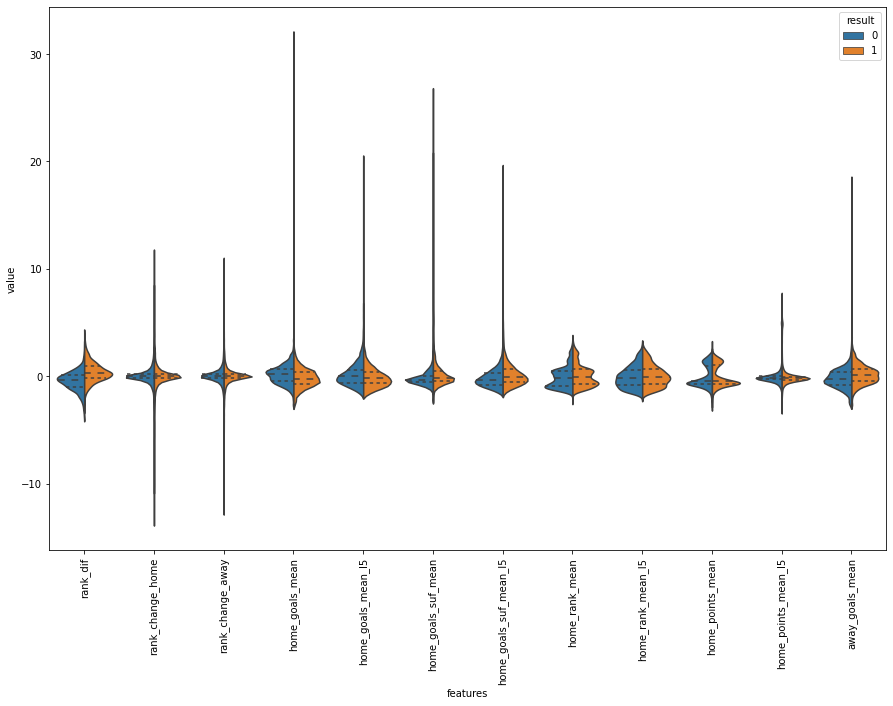

In [60]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

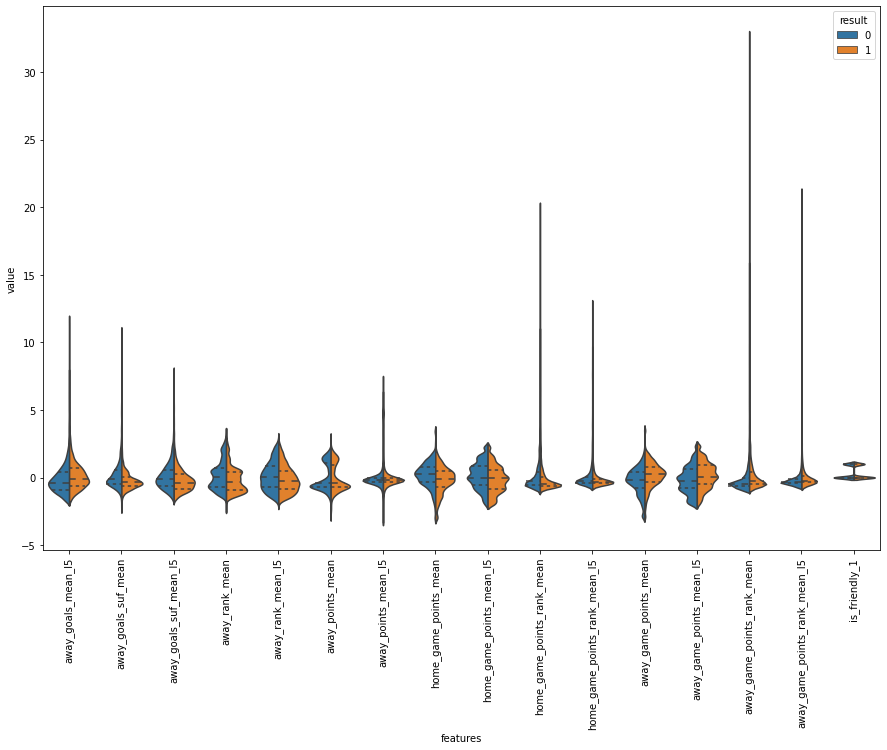

In [61]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

С графиками мы обнаруживаем, что разница в рангах является единственным хорошим разделителем данных. Но мы можем создавать функции, которые получают различия между домашней и выездной командой и анализируют, хорошо ли они разделяют данные.

In [62]:
dif = df.copy() # Dataframe для обработки различий
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

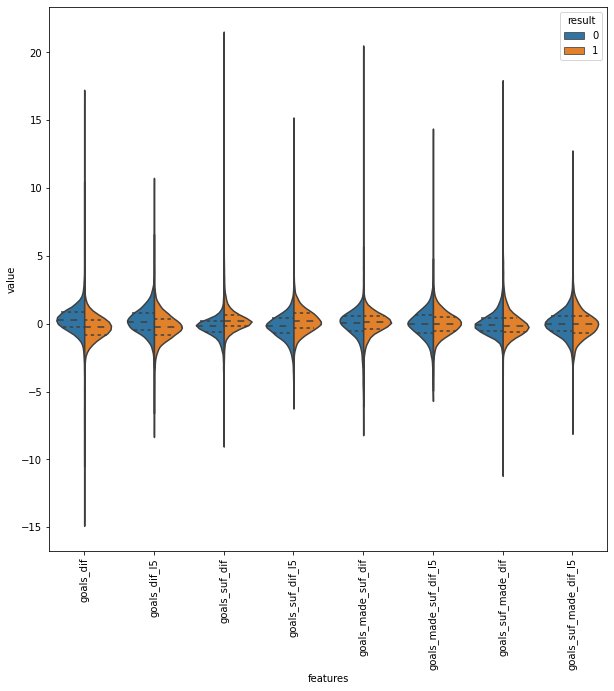

In [63]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = data2["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="result", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

На этом графике мы видим, что разница в голах является хорошим разделителем, и разница в голах тоже. 

Теперь у нас есть 5 функций:
- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5

Мы можем создавать другие функции, такие как разница в набранных очках, разница в очках, набранных рангом, и разница в ранге.

In [64]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Кроме того, мы можем рассчитать забитые и пропущенные голы по рангу и проверить эту разницу.

In [65]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

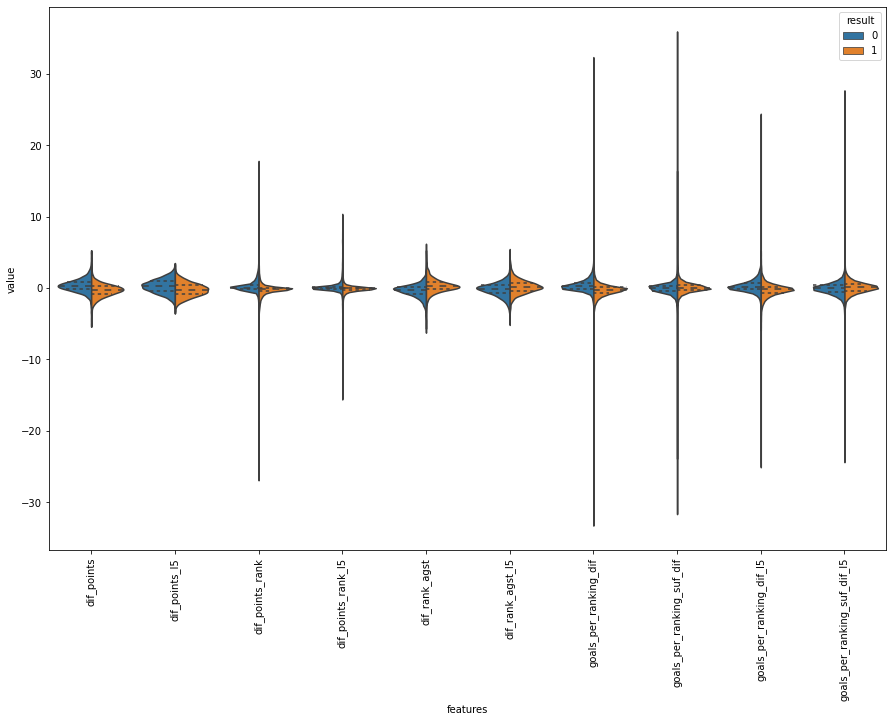

In [66]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = data2["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Из-за низких значений график скрипки не был хорошим выбором для анализа того, действительно ли признаки разделяют данные в этом случае. Затем мы увидим boxplot:

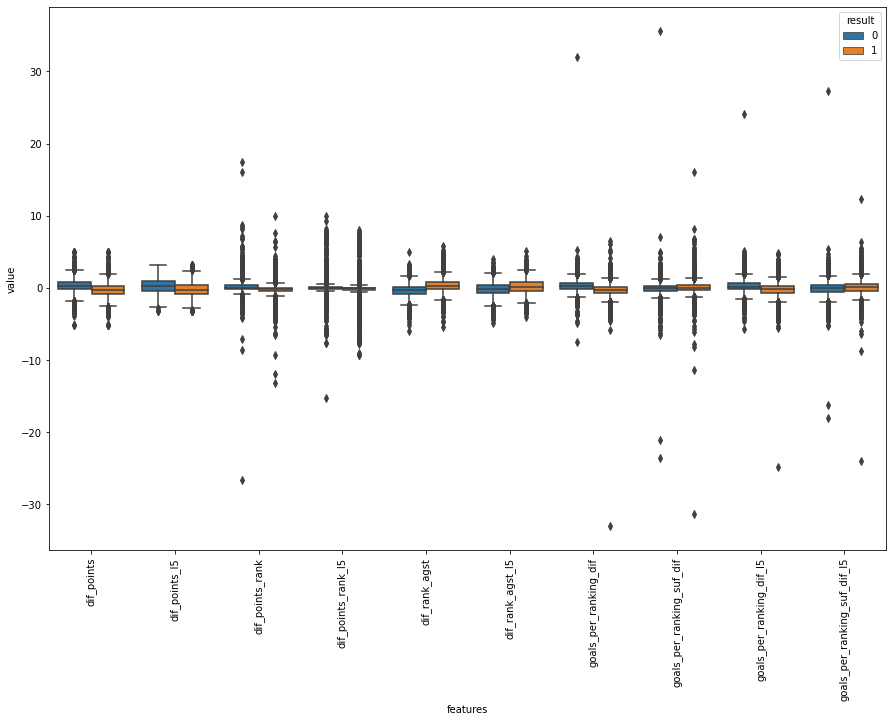

In [67]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="result", data=violin)
plt.xticks(rotation=90)
plt.show()

Разница очков (полные и последние 5 игр), разница очков в зависимости от рейтинга (полные и последние 5 игр) и разница в рейтинге (полные и последние 5 игр) являются хорошими характеристиками. Кроме того, некоторые из сгенерированных функций имеют очень похожие распределения, которые будут проанализированы с помощью диаграмм рассеяния.

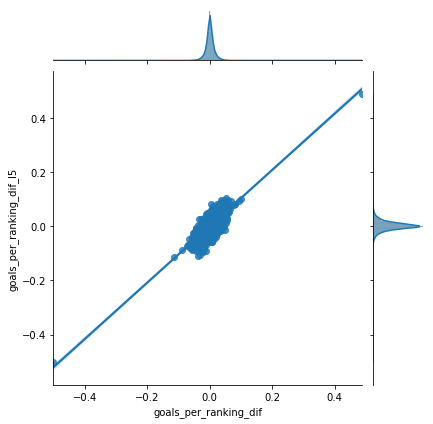

In [68]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Разница голов по рейтингу столкновений и его последняя версия 5 игр имеют очень похожие распределения. Итак, мы будем использовать только версию (goals_per_ranking_dif).

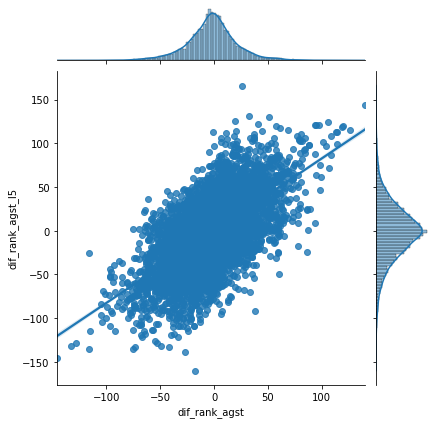

In [69]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

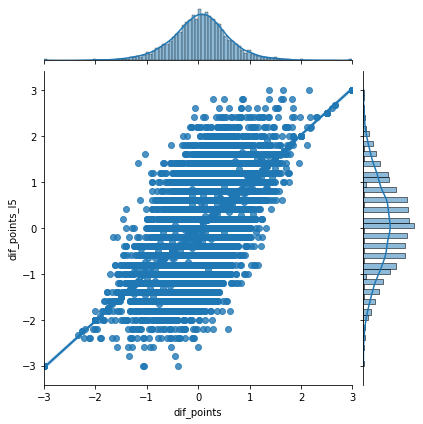

In [70]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

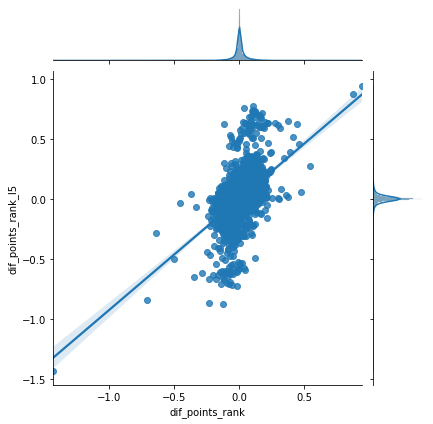

In [71]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

Что касается различий в рангах, игровых очках по рангам и средних игровых очках по рангам, две версии (полная и 5 игр) не так уж похожи. 

Исходя из этого, окончательные характеристики:
- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [72]:
def create_db(df):
    columns = ["home_team", "away_team", "result", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "result", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_1"]]
    return model_df.reset_index(drop=True)

In [73]:
model_db = create_db(df)

In [74]:
model_db

,home_team,away_team,result,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_1
0,Ethiopia,Chad,0,20.0,-1.000000,-1.0,0.000000,0.0,-0.015625,52.000000,52.0,0.000000,0.000000,1
1,Algeria,Tanzania,1,-78.0,0.000000,0.0,1.000000,1.0,0.020791,-82.000000,-82.0,-0.008621,-0.008621,0
2,Andorra,Russia,1,185.0,-1.000000,-1.0,1.000000,1.0,-0.023256,20.000000,20.0,-0.069767,-0.069767,0
3,Armenia,Republic of Ireland,1,60.0,1.000000,1.0,2.000000,2.0,0.015385,60.000000,60.0,0.000000,0.000000,0
4,Belgium,Germany,1,44.0,-2.000000,-2.0,-1.000000,-1.0,-0.068966,22.000000,22.0,-0.034483,-0.034483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,Malaysia,Maldives,0,-8.0,-0.010776,0.6,-0.366649,-0.8,0.000630,-10.325251,-19.6,0.001845,0.000855,1
9837,Vietnam,Philippines,0,-37.0,0.202249,1.8,0.058659,-1.2,0.003233,-21.189474,-47.4,0.002502,0.017688,1
9838,Croatia,Morocco,0,-10.0,0.059221,0.2,0.299086,0.6,0.014309,-27.355525,1.6,0.038223,-0.086905,0
9839,Singapore,Maldives,0,6.0,-0.245378,0.0,-0.230740,0.0,-0.000677,-16.252504,-38.8,0.001197,-0.002123,1


# Выделение целевой переменной

In [75]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [76]:
X

,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_1
0,20.0,-1.000000,-1.0,0.000000,0.0,-0.015625,52.000000,52.0,0.000000,0.000000,1
1,-78.0,0.000000,0.0,1.000000,1.0,0.020791,-82.000000,-82.0,-0.008621,-0.008621,0
2,185.0,-1.000000,-1.0,1.000000,1.0,-0.023256,20.000000,20.0,-0.069767,-0.069767,0
3,60.0,1.000000,1.0,2.000000,2.0,0.015385,60.000000,60.0,0.000000,0.000000,0
4,44.0,-2.000000,-2.0,-1.000000,-1.0,-0.068966,22.000000,22.0,-0.034483,-0.034483,0
...,...,...,...,...,...,...,...,...,...,...,...
9836,-8.0,-0.010776,0.6,-0.366649,-0.8,0.000630,-10.325251,-19.6,0.001845,0.000855,1
9837,-37.0,0.202249,1.8,0.058659,-1.2,0.003233,-21.189474,-47.4,0.002502,0.017688,1
9838,-10.0,0.059221,0.2,0.299086,0.6,0.014309,-27.355525,1.6,0.038223,-0.086905,0
9839,6.0,-0.245378,0.0,-0.230740,0.0,-0.000677,-16.252504,-38.8,0.001197,-0.002123,1


In [77]:
y.head()

,result
0,0
1,1
2,1
3,1
4,1


#### Разделение набора данных на обучающую и тестовую выборки.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

#### Вспомогательная функция

In [79]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

## ML Models

# Bagging Vs Boosting

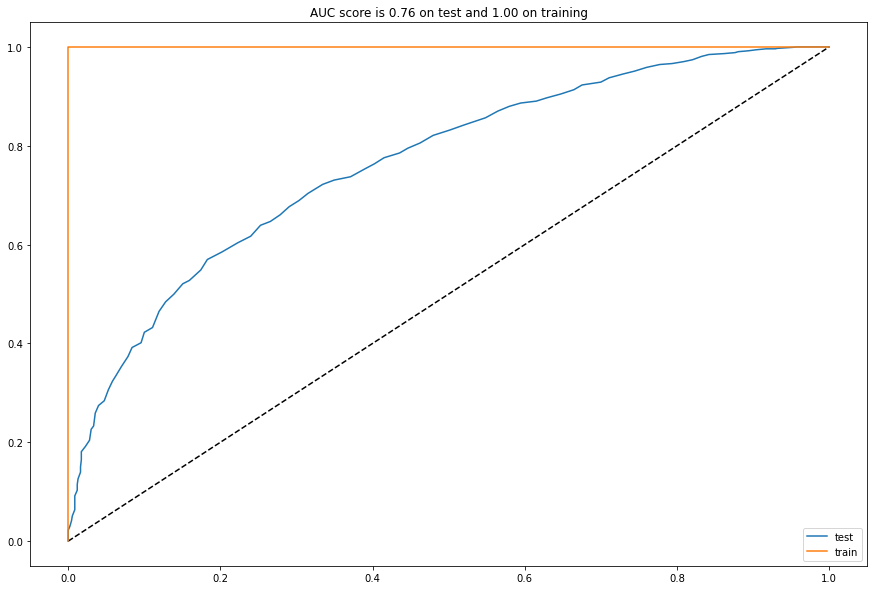

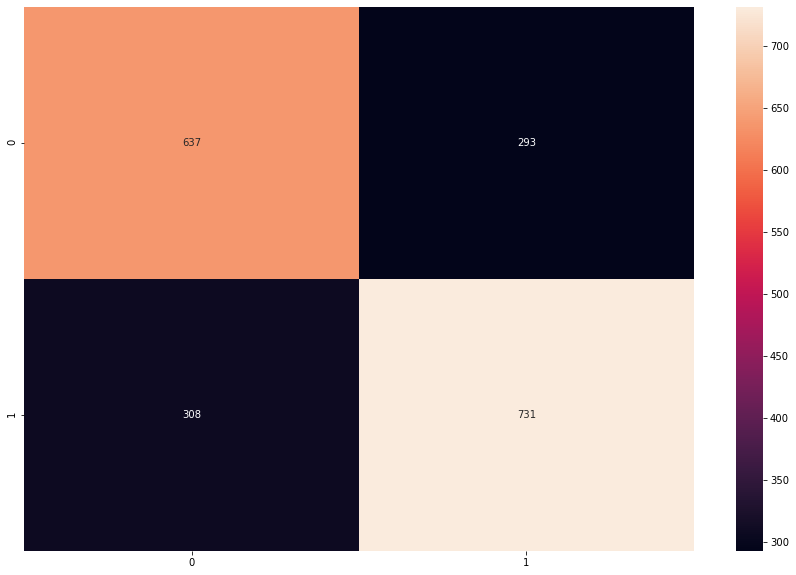

In [80]:
rf = RandomForestClassifier(random_state=1)

rf.fit(X_train.values, np.ravel(y_train))

analyze(rf)

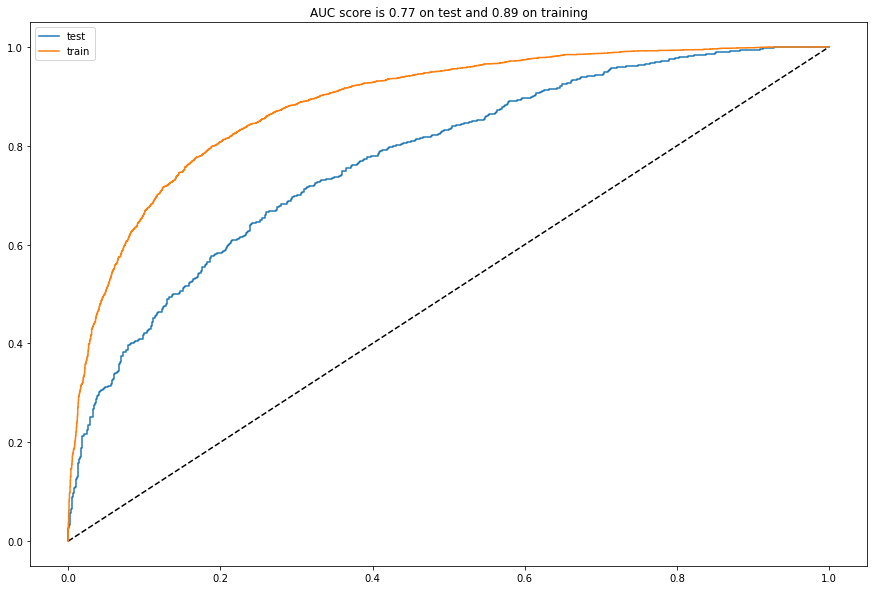

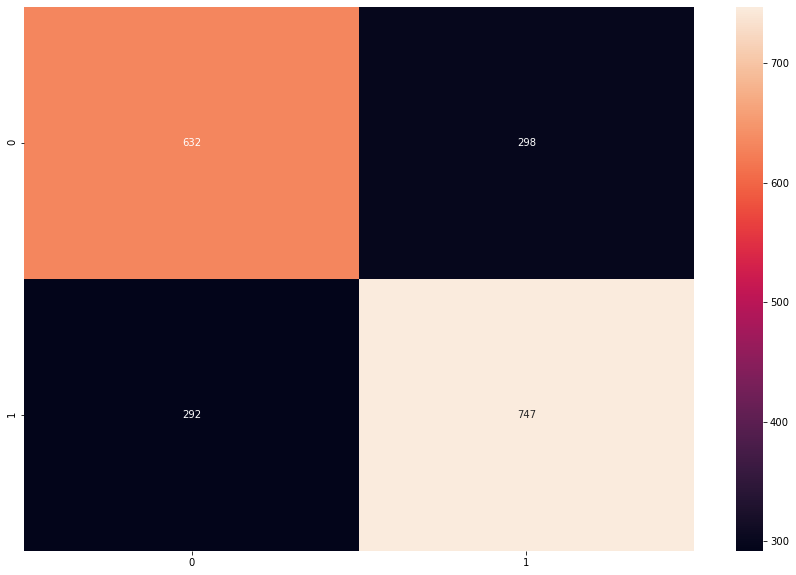

In [81]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))
rf_f = rf_cv.best_estimator_
analyze(rf_f)

# GradientBoostingClassifier
#### Этот алгоритм поэтапно строит аддитивную модель, позволяя оптимизировать произвольные дифференцируемые функции потерь.
- На каждом этапе деревья регрессии n_classes_ соответствуют отрицательному градиенту функции потерь, например. потеря бинарного или мультиклассового журнала.

- Бинарная классификация представляет собой особый случай, когда индуцируется только одно дерево регрессии.

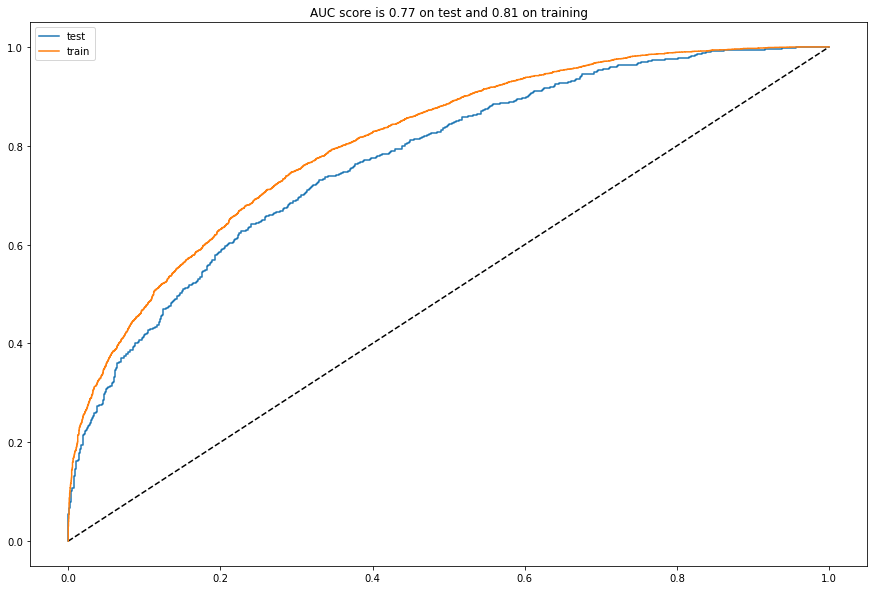

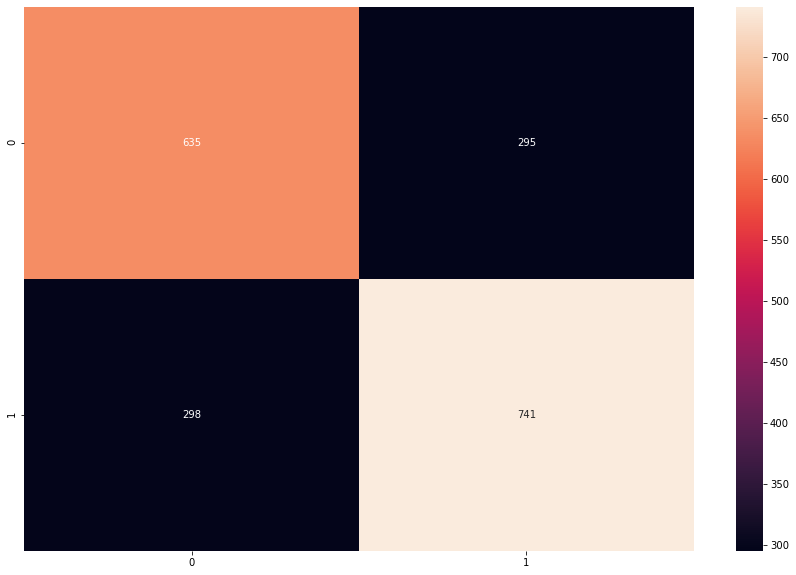

In [82]:
gb = GradientBoostingClassifier(random_state=5)
gb.fit(X_train.values, np.ravel(y_train))
analyze(gb)

## Extreme Gradient Boosting (XGBoost)

C:\Users\Ivan\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


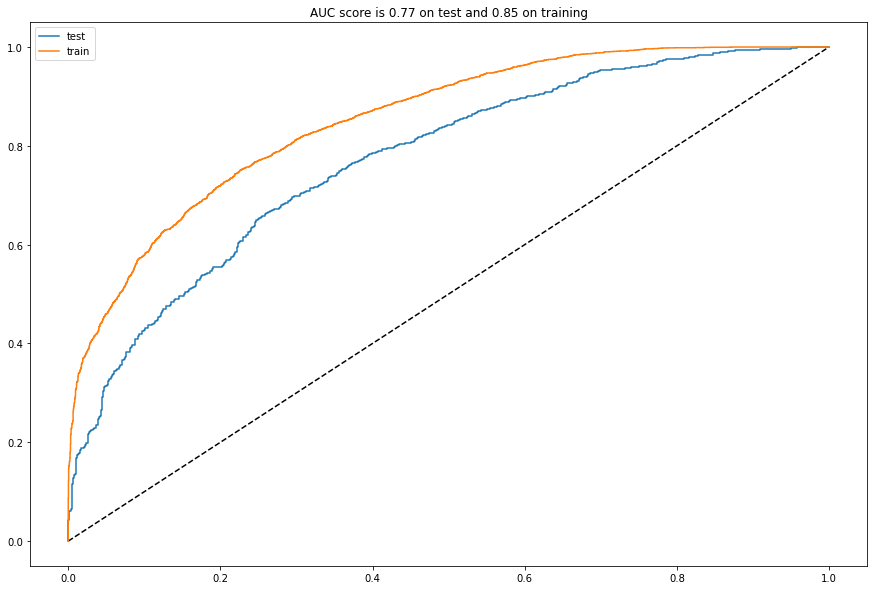

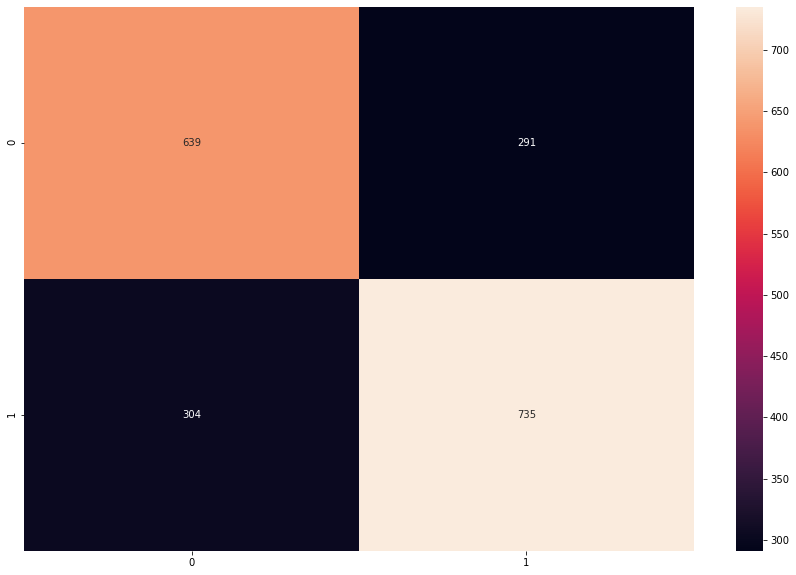

In [83]:
xgb = XGBClassifier(n_estimators=1000,learning_rate=0.01)
xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=100,verbose=False)
analyze(xgb)

## Grid Search
- Это исчерпывающий поиск по указанным значениям параметров для оценщика.

- GridSearchCV реализует метод «подгонки» и «оценки». Он также реализует «score_samples», «predict», «predict_proba», «decision_function», «transform» и «inverse_transform», если они реализованы в используемом оценщике.

- Параметры оценщика, используемого для применения этих методов, оптимизируются перекрестным поиском по сетке параметров.

## Гиперпараметры

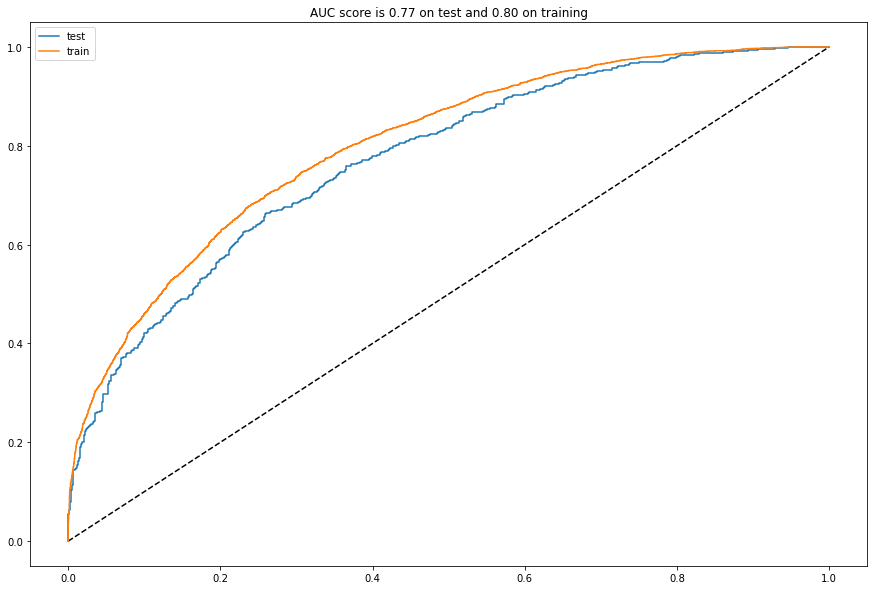

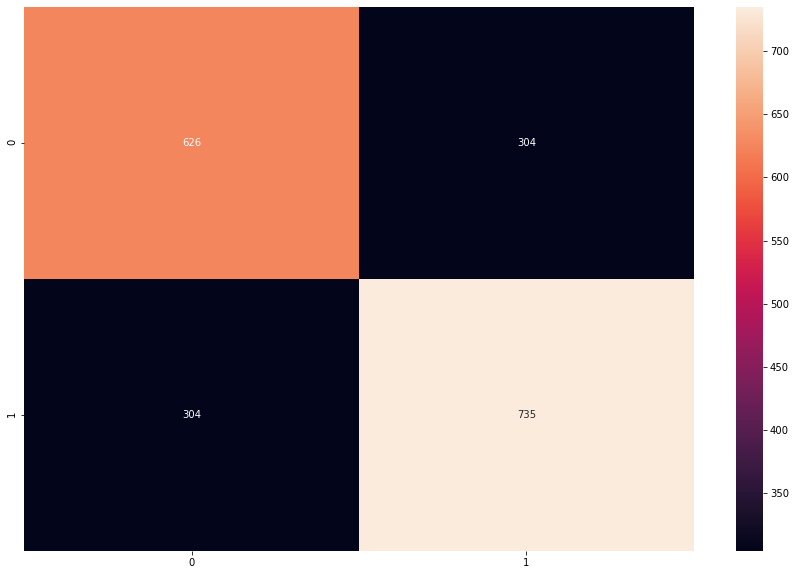

In [84]:
params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)
gb_cv.fit(X_train.values, np.ravel(y_train))
gb_b = gb_cv.best_estimator_
analyze(gb_b)